# 3D XY Model with Wolff Cluster Update

Physics 514 Final Project by Nathan Lydick

## Introduction

### Ising and XY Models
My project is essentially an extension of the Ising model. The Ising model is a series of "Up" or "Down" ($\sigma=±1$) spins on a discrete grid. The spins interact with one another following the Hamiltonian (in the absence of an external field)
$$ H = -\sum_{i,j}J_{ij}\sigma_i\sigma_j$$.
Typically, as we did in class, we assume J is some constant value for the nearest neighbors and 0 elsewhere, giving us a sum (where $\left<i,j\right>$ indicates the sum is over only the nearest neighbors)
$$ H = -J\sum_{\left<i,j\right>}\sigma_i\sigma_j$$.

The XY model can be seen as an extension of the Ising model. Rather than a 1D spin (spins are unit vectors in the given dimension, so ±1), we allow 2D spins. These can either be represented in a polar form as a single angle $\theta$ or in the Cartesian form $\vec{s}=(\cos\theta,\sin\theta)$. The Hamiltonian then involves the dot product for the neighboring spins rather than just scalar multiplication (here I will show the nearest neighbor form that I simulated, though the nearest neighbor case follows the same pattern):
$$ H = -J\sum_{\left<i,j\right>}\vec{s}_i\cdot\vec{s}_j$$.

The XY and Ising models allows a number of dimensions and lattices for the grid of spins. In class, we simulated the model with a square 2D grid. Here, I simulated the XY model with a 3D cubic grid. Since our computers are limited to finite grids, I simulated the grid with periodic boundary conditions for an NxNxN grid.

### Cluster Updates
These models are amenable to Monte Carlo simulations. For the homework, we used the Metropolis update algorithm for the 2D Ising model. That algorithm involves selecting a random point on the grid and flipping the spin at that point based on the change in energy associated with that point and the temperature we are simulating. We always accept changes moving to lower energy, and we accept changes moving to higher energy with probability $e^{-\beta\Delta H}$. Because we only flip a single spin, though, this update algorithm is slow near the critical temperature, where magnetic domains have a size near the size of the grid.

To overcome the slowing down near critical temperatures, there are a number of Cluster update algorithms that help mitigate the slowing by flipping more than one spin at a time. One such method is the Wolff cluster update algorithm. This algorithm, rather than flipping a single spin, flips a cluster at a time. This cluster is formed by picking a random site on the grid and adding it to the cluster. We then iterate over the neighbors of the cluster, and conditionally bind each neighboring spin to the cluster with probability $p=1-e^{-2J\beta}$ if the spins are parallel. We repeat the growth until no more bonds can be made (each bond can be formed only one time, we don't re-attempt making the same bond more than once per cluster update). The algorithm looks like:

- Add random point to the frontier (set sites to be added to the grid).
- For every point $i$ on the frontier:
  - Add the point $i$ to the cluster and remove from the frontier.
  - For each neighboring site $j$, that is not in the cluster:
     - If the spins are aligned, add $j$ to the frontier with probability $p=1-e^{-2J\beta}$.
  - Flip the spin at point $i$
  
To avoid a set data structure and/or removing elements from the middle of an array, a check can also be inserted before 1 to ensure the point $i$ has not already been added to the cluster. If it was added previously, we just continue with the next element. This means we only need to remove the first element from the frontier, and don't have to worry about adding duplicates to it and/or removing elements from the middle of the frontier. Note that the algorithm can also be formulated recursively, but an iterative approach avoids issues with stack overflows. As such I went with the iterative algorithm above.

To perform these Monte Carlo simulations with the XY model, a slight modification has to be made. For each Monte Carlo step, in addition to a random point (the only point for the Metropolis alogithm or the starting point for the Wolff update algorithm), a random unit vector $\vec{r}$ is also chosen, which will be the vector normal to the plane that the spins will be mirrored over. This choice maps the vector spins on the grid to scalar values as we have used in the update algorithms, by mapping $J_{ij} = (\vec{r}\cdot\vec{s}_i)(\vec{r}\cdot\vec{s}_j)$ and $\sigma_i=\mathrm{sign}(\vec{s}_i\cdot\vec{r})$, so we no longer have a single constant $J$. Flipping the spin is then the reflection along $\vec{r}$ given by $\vec{s}_i\to\vec{s}_i-2\vec{r}(\vec{r}\cdot\vec{s}_i)$.

## Methodology

To create the simulation, I started with just simulating the Ising model in 2D using the Metropolis update algorithm. We already have the results we should expect from that from our homework, as well as a working implementation. As such, it was a suitable choice to ensure that my C++ implementation was giving correct results. Once that was working, I added in the Wolff update, and used the earlier results as a comparison to ensure I had implemented it correclty, as the algorithm was entirely new to me.

Once the Ising model was working in 2D with both algorithms, I extended the code to simulate the Ising model on a 3D grid. This involved few changes, essentially just adding an extra index `z` to the grid and to function calls and checking an additional two nearest neighbors. The Wolff update algorthm was a little more complicated, as I have to store the indices for the frontier points, but it was still a relatively painless process.

Once the algoirthms were working for the 3D Ising model, I made the final extension to handle the XY spins. This was a more complicated process than the extension to 3D was. C++ does not have a built in 2D vector type, so I had to write a simple one (which handles few things beyond addition, scalar multiplication, the dot product (vector multiplication), and reflection over another unit vector. Beyond that, I had to re-write the grid initialization to handle the vector type, and each update algorithm to select a random direction vector and not just a random point. I also had to rewrite the probability calculations to account for the dot product with that vector $r$ (or `along` in the code). Fortunately, the storage of the magnetizations were already largely in order once I changed the typedef from `using Vec = double` to `using Vec = Vec2` (the `Vec` type represents the type for a single spin), so some of the more tedious details were already handled as I was planning on the XY spins from the start.

For the probabilistic acceptance (of flipping the spins or adding to the cluster) the implementation just compares a uniformly distributed $[0,1)$ random number to the probability $p$, making use of the fact that $e^x > 1$ for $x > 0$ to write the random events that depend on the spins being aligned or not as a single if statement rather than `if (parallel) if (Rand() < p) DoThing();`.


## Results

Note: Results for the 2D and 3D Ising models will be deferred to the Appendices, as the focus of my project was the 3D XY model.

Like the Ising model, the XY model Monte Carlo simulation with the proper probabilities chosen for the updates satisfy the detailed balance condition and for the system and allow us to study the bahavior of the Energy and Magnetization as a function of temperature. In addition, we can further extract the specific heat and the magnetic susceptibility from the variance of the energy and (absolute) magnetization over time. The results from various runs are displayed in Figure 1. You can see that there is a clear change in the slope for the energy at the critcal temperature (about 2.201). Further, the system clearly switches from a ferromagnetic state below the critical temperature, with non-zero average magnetization, to a paramagnetic state with 0 magnetization. At the transition, you can see a sharp spike in the magnetic susceptibility. The specific heat, however, does not have as clear a spike as the susceptibility, perhaps because the change in energy is less drastic than the change in magnetization.

![image.png](Results/Params.png)
![image.png](Results/Params-Near-Tc.png) **Figure 1**: Energy density, Magnetization, Specific Heat, and Magnetic Susceptibility as a function of Temperature T, and second plots for each showing the region very near $T_c$.

To ensure our results are good, we should also inspect the plots of Energy/Magnetization as a function of temperature to ensure that we have a sufficient number of iterations for the results to come into a thermal equilibrium. You can see a couple of examples of such plots in Figure 2.

![image.png](Results/Run-N-40.png) 
![image.png](Results/Run-N-30.png) 
![image.png](Results/Run-N-10.png) 
**Figure 2**: Example runs showing that the simulation has thermalized sufficiently for our averages (we only average the last 20% of the data. Note that the results are plotted with only 400 samples, to aid in the visibility of the lines (as 50x10k+ points is a lot of data to plot). 

From the ArXiv references, we know that the critical temperature of the 3D XY model (with $k_B=J=1$) is around $T_c=2.201$ This corresponds well with the above results. We can also use the Binder Cumulant (the Kurtosis of the order parameter, per Wikipedia) as a measure of our critical temperature, which gives us a very sharp transistion at the critical temperature. For the Ising model it is aparently stationary (per my classmate's presentations), though it does not appear to be for the 3D XY model, probably because there are different critical exponents.


![image.png](Results/Binder-Cumulant.png)
![image.png](Results/Binder-Cumulant-Near-Tc.png)
**Figure 3**: The Binder cumulant, which is the Kurtosis of the order parameter, and displays a very sharp transition at the critical temperature.

Further study into estimating the value of the critical exponents should be possible with my code and more time running it. But since I already re-implemented the project from the ground up in C++ after an initial attempt in Python and even now running it for nearly a day gives results that seem much less precise in the critical temperature than published work, I will refer you to them (and/or Wikipedia) if you are interested in the critical exponents. That said, my code does seem to match the critical temperature well, so were it run for a longer amount of time, perhaps on a larger grid, I would expect it to provide data that the exponents could be estimate from.

## Code `main.cpp`
This compiled acceptably using gcc version 9.3.0 (Ubuntu 9.3.0-17ubuntu1~20.04). Your results may vary using other compilers. I used CMake to compile it, so if you would like to compile it on your own I will refer you to Github https://github.com/SirNate0/3D-XY-Model where I have the CMake files and such. The comipile commands were:

    /usr/bin/g++    -O3 -DNDEBUG   -std=gnu++11 -o CMakeFiles/Ising.dir/main.cpp.o -c /home/nathan/Documents/School/CP514/Ising/main.cpp
    /usr/bin/g++  -O3 -DNDEBUG   CMakeFiles/Ising.dir/main.cpp.o  -o Ising 


And the code:
```cpp
#include <iostream>
#include <random>
#define _USE_MATH_DEFINES
#include <cmath>
#include <bits/stdc++.h>

//#undef assert
//#define assert(...) (void(0))

using namespace std;

/// Minimal 2 component vector implementation for the XY spins
struct Vec2
{
    /// Components.
    double x,y;

    /// Dot product.
    double operator* (const Vec2& rhs) const
    {
        return x*rhs.x + y*rhs.y;
    }
    /// Uniformly scale.
    Vec2 operator* (double s) const
    {
        return {x*s,y*s};
    }
    /// Uniformly scale with other order of operands.
    friend Vec2 operator* (double s, const Vec2& b)
    {
        return {b.x*s,b.y*s};
    }
    /// Negate a vector.
    Vec2 operator-() const
    {
        return {-x,-y};
    }
    /// Add two vectors.
    Vec2 operator+ (const Vec2& rhs) const
    {
        return {x+rhs.x, y+rhs.y};
    }
    /// Add assign a vector.
    Vec2& operator+= (const Vec2& rhs)
    {
        x+= rhs.x;
        y+= rhs.y;
        return *this;
    }
    /// Reflect a vector along another vector (so over the plane perpendicular to that other vector).
    /// Assumes the other vector is a direction vector.
    Vec2 reflected(const Vec2& along) const
    {
        double dot = along * (*this);
        dot *= -2;
        auto delta = along*dot;
        auto out = (*this) + delta;
//        assert(abs(out.length()-1) < 1e-3); // Confirm that we have retained the unit length.
        return out;
    }
    /// Returns the length of the vector.
    double length() const
    {
        return sqrt(*this * *this);
    }

};

// ---------------
// Create the grid
// ---------------

// Typedef the vector so we could possibly switch to other dimensionality for our spin.
using Vec = Vec2;
// The energy scaling, the coefficient multiplied by the energy from two neighboring (unit length) spins.
constexpr double J = 1;
// The number of elements along one side of the grid.
constexpr int N = 40;
// The actual grid.
Vec2 grid[N][N][N];
// The number of temperatures to iterate over.
constexpr int NT = 50;
// How many steps to simulate.
constexpr int steps = 100e3;
// The lowest temperature to simulate.
constexpr double T0 = 2.05; // lowest temperature
// The range of temperatures to simulate (i.e. simulate steps in [T0,T0+TRange]
constexpr double TRange = 0.25; // delta to highest temperature

// Define this to have all spins start up, rather than in a random direction.
//#define START_UP
// The number of dimensions in the grid, used in writing the output parameters.
#define DIMENSIONS 3



// ------------------------------------------------------------------
// Setup random number generator for float and integer distributions.
// ------------------------------------------------------------------

// We use a fixed seed for repeatable results (for debugging), rather than seeding from the random device.
//std::random_device rd;
// Mersenne Twister is a better random number generator, but it's slower.
//std::mt19937 e2(rd());
// We want fast computations so we'll use a faster one that is moderately good.
ranlux48_base e2(32);//rd());
// Class to get a real (floating point) random number between [0,1).
std::uniform_real_distribution<> dist(0, 1);
// Class to get a real (integer) random number between [0,N).
std::uniform_int_distribution<> randint{0, N-1};
// Class to get a random boolean.
std::uniform_int_distribution<> randbool{0, 1};

/// Get random int [0,N).
inline int RandInt()
{
    return randint(e2);
}

/// Get random double [0,1).
inline double Rand()
{
    return dist(e2);
}

/// Get random vec2 direction.
inline Vec2 RandVec()
{
    double angle = Rand()*M_PI*2;
    return{cos(angle),sin(angle)};
}


// ---------------------------
// Grid interaction functions.
// ---------------------------

/// Set's a random value for the grid at x and y
inline void SetRandom(int x, int y, int z)
{
    grid[x][y][z] = RandVec();
}

/// Convenience function to get the spin at the given x and y
inline Vec Val(int x, int y, int z)
{
    return grid[x][y][z];
}

/// Safer convenience function to get the spin at the given x and y, applying %N wrapping.
inline Vec SVal(int x, int y, int z)
{
    return grid[(x+N)%N][(y+N)%N][(z+N)%N];
}

/// Flips the grid value at the given point.
inline void Flip(const Vec2& along, int x, int y, int z)
{
    grid[x][y][z] = grid[x][y][z].reflected(along);
}


// -----------------------------------
// Measurement functions for the grid.
// -----------------------------------

/// Returns the energy for the grid. Counts each neighbor pairing only once.
double Energy()
{
    double energy = 0;
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            for (int z = 0; z < N; ++z)
            {
                energy += -J*(Val(x,y,z)*Val((x+1)%N,y,z));
                energy += -J*(Val(x,y,z)*Val(x,(y+1)%N,z));
                energy += -J*(Val(x,y,z)*Val(x,y,(z+1)%N));
            }
    return energy;
}

/// Returns the magnetization of the grid.
Vec Magnetization()
{
    Vec mag{0,0};
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            for (int z = 0; z < N; ++z)
                mag += Val(x,y,z);
    return mag;
}


// -------------------------
// Initialization algorithm.
// -------------------------

/// Resets the grid. Get's starting magnetization and energy.
inline void ResetGrid(double& energy, Vec& magnetization)
{
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            for (int z = 0; z < N; ++z)
            {
#ifdef START_UP
                grid[x][y][z] = {1,0};
#else
                SetRandom(x,y,z);
#endif
                assert(abs(grid[x][y][z].length()-1) < 1e-3);
            }

    energy = Energy();
    magnetization = Magnetization();
}

// ------------------
// Update algorithms.
// ------------------

/// Performs a step of the metropolis update algorithm.
void MetropolisUpdate(double beta, double& energy, Vec& magnetization)
{
    int x = RandInt();
    int y = RandInt();
    int z = RandInt();
    auto along = RandVec();

    auto pt = Val(x,y,z);
    Vec neighbors[] = {SVal(x+1,y,z), SVal(x-1,y,z),
                       SVal(x,y+1,z), SVal(x,y-1,z),
                       SVal(x,y,z+1), SVal(x,y,z-1)};
    double dH = 0;
    Vec2 dM{0,0};
    // By doubling the values, we account for the energy counting each pair once, regardless of order,
    // with the energy +J to -J, for example, so dH would be -2J, not -J.
    for (auto n : neighbors)
        dH += 2*J*(along*pt)*(along*n);

    // For decreasing energy (dH<0) we always accept as thresh > 1, so our random number will be less than it.
    // Otherwise we conditionally accept it based on the inverse temperature beta.
    double thresh = exp(-dH*beta);
    double p = Rand();
    if (p < thresh)
    {
        Flip(along,x,y,z);
        dM = -2*pt;
    }
    else
    {
        dH = 0;
    }

//    assert(abs(Energy()-energy - dH) < 1e-4);

    energy += dH;
    magnetization += dM;
}

/// Perform Wolff cluster update.
void WolffUpdate(double beta, double& energy, Vec& magnetization)
{
    // Get a random point and a random direction to flip along.
    int x = RandInt();
    int y = RandInt();
    int z = RandInt();
    Vec2 along = RandVec(); // Effectively, we use this vector to map the XY model to an Ising model with spins [-1,1] instead of just +/-1.

    /// Setup a frontier array of the next points that will be added to the grid. To avoid possibly
    /// costly memory moves, we use the grid size times a few and use it as a buffer that we only
    /// add elements further down the line on while we just move the starting position along the buffer.
    constexpr int MAX_FRONTIER = N*N*N*3;
    int frontierIdcs[MAX_FRONTIER];
    bool cluster[N*N*N] = {false,};
    memset(cluster,false,sizeof cluster);

    // Initialize our frontier with the randomly chosen point.
    int frontierSize = 1;
    int frontierPos = 0;
    frontierIdcs[0] = x*N*N+y*N+z;

    // Struct to hold xy indices for convenience.
    struct grid_indices
    {
        // The xyz indices.
        int x,y,z;
    };
    // Method to add a point to the frontier (the points that will be added to the cluster).
    auto AddFrontier = [&](const grid_indices& n)
    {
        if (frontierPos+frontierSize >= MAX_FRONTIER)
        {
            memmove(frontierIdcs,frontierIdcs+frontierPos,frontierSize*sizeof(int));
            frontierPos=0;
            cout << "Reset frontier location \n";
        }
        frontierIdcs[frontierPos+frontierSize] = n.x*N*N+n.y*N+n.z;
        frontierSize += 1;
    };

    // Counters for the number of iterations and rejected bonds, useful for debugging.
    int iterations = 0, rejections = 0;

    // As long as we have points in our frontier
    for (; frontierSize; ++frontierPos,--frontierSize)
    {
        // Get the cluster index, skip if it is already in the cluster, and convert back to the xyz indexing.
        int i = frontierIdcs[frontierPos];
        if (cluster[i])
            continue;
        int ix = i / N / N;
        int iy = (i/N) % N;
        int iz = i % N;

        // Add this point to the cluster
        cluster[i] = true;

        // Compare to the neighboring values
        auto v = Val(ix,iy,iz);
        for (grid_indices n : {grid_indices{1,0,0},grid_indices{-1,0,0},
                               grid_indices{0,1,0},grid_indices{0,-1,0},
                               grid_indices{0,0,1},grid_indices{0,0,-1}})
        {
            // Get the proper neighbor index from the relative indexing used above.
            n.x = (N+ix+n.x)%N;
            n.y = (N+iy+n.y)%N;
            n.z = (N+iz+n.z)%N;
            // Get the spin value at the point.
            auto nv = Val(n.x,n.y,n.z);
            // If it is parallel add it to the frontier with probability 1-exp(-2*J*beta*spin*spin_neighbor)
            // If it's not parallel, p < 0, so Rand() will never be less than it. Note that (along*v) is a dot product.
            float p = (1 - exp(-2*J*beta*(along*v)*(along*nv)));
            if (Rand() <  p)
                AddFrontier(n);
            else
                // Increment our rejectiosn count
                rejections++;
        }
        // And now that we've finished with this point, go ahead and flip it.
        Flip(along,ix,iy,iz);

        // Increment our iterations count.
        iterations++;
    }

    // Recalculate energy and magnetization.
    energy = Energy();
    magnetization = Magnetization();
}


// Initialize energy and magnetization vectors.
// Energy is padded by 1 to also output the inverse temperature as the final element.
double energies[NT][steps+1] = {0,};
Vec magnetizations[NT][steps] = {0,};


// The main loop.
int main()
{
    cout << "Starting" << endl;

    // Iterate over our temperatures.
    for (int b = 0; b < NT; ++b)
    {
        // Print as a status update.
        cout << b << " of " << NT << endl;

        // Initialize our grid for this temperature.
        double energy;
        Vec2 magnetization;
        ResetGrid(energy,magnetization);

        // Calculate the current temperature from [T0,T0+TRange].
        double T = NT > 1 ? T0 + b*TRange/(NT-1) : T0;
        // And beta from temperature.
        double beta = 1/T;
        // And store it in the energies vector (useful for debugging).
        energies[b][steps] = beta;

        // The update loop for this temperature.
        for (int i = 0; i < steps; ++i)
        {
            // The actual update
//            MetropolisUpdate(beta,energy,magnetization);
            WolffUpdate(beta,energy,magnetization);

            // Store the energy and magnetization in the arrays
            energies[b][i] = energy;
            magnetizations[b][i] = magnetization;

            // Debugging check.
//            if (i % 1000 == 0 && abs(energy - Energy()) > 1e-5)
//            {
//                cout << "Failed with E = " << energy;
//                cout << " rather than E = " << Energy() << endl;
//                assert(false);
//            }

            // 10% progress updates.
            if ((1+i)%(steps/10)==0)
                cout << "\t ITERATION " << i << endl;
        }
    }
    cout << "Finished" << endl;

    // Write to files. Binary for energy and magnetization, text for the parameters.
    ofstream outE("energy.dat", ios::out | ios::binary);
    ofstream outM("magnetization.dat", ios::out | ios::binary);
    ofstream outP("params.txt", ios::out);
    if(!outE || !outM || !outP) {
      cout << "Cannot open file.";
      return 1;
     }

    // Actually write the data.
    outE.write((char *) &energies, sizeof energies);
    outM.write((char *) &magnetizations, sizeof magnetizations);

    outP << DIMENSIONS << " " << N << " " << NT << " " << steps << " " << T0 << " " << TRange;

    // Close files (flushes the buffer, which must be done before calling the plot script).
    outE.close();
    outM.close();
    outP.close();

    // Attempt to call the python3 plot script to plot the calculated data.
    cout << "Output written. \nAttempting to call the python3 plot script." << endl;
    return system("python3 Plot.py");
}

```

## Code `Plot.py`

The code for plotting a single run. Called by the C++ code so it doesn't have to be run separately.

```py
#!/bin/python3
import matplotlib.pyplot as plt
import numpy as np

energies = np.fromfile('energy.dat',dtype=np.double)
mags = np.fromfile('magnetization.dat',dtype=np.double)
dim,N,NT,steps,T0,Trange = np.genfromtxt('params.txt')
dim = int(dim)
N = int(N)
NT = int(NT)
steps = int(steps)
T = np.linspace(T0,T0+Trange,NT)
energies.shape = (NT,steps+1)
mags.shape = (NT,steps,-1)
vecDim = mags.shape[2]

beta = energies[:,-1]
energies = energies[:,:-1]

print(N,NT,steps)
print(mags)
print(energies)

thermalize = int(steps*0.9)


avg_energy = np.average(energies[:,thermalize:],axis=1)
currentM_abs = np.average(np.linalg.norm(mags[:,thermalize:],axis=2),axis=1)

chi_T = (np.average(np.linalg.norm(mags[:,thermalize:],axis=2)**2,axis=1)-currentM_abs**2)/(T*N**dim)
C_T = (np.average(energies[:,thermalize:]**2,axis=1)-avg_energy**2)/(T*N**dim)

#plt.plot([1,2],[3,4])
plt.subplot(211)
plt.plot(energies[:,::100].T)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.subplot(212)
plt.plot(np.linalg.norm(mags[:,::100],axis=2).T)
plt.xlabel("Iterations")
plt.ylabel("|Magnetization|")
#plt.subplot(313)
#plt.plot((mags[0,::100,:]).T)
##plt.plot((mags[1,::100,1]).T,':')
#plt.xlabel("Iterations")
#plt.ylabel("Magnetization")
#plt.figure()
#plt.imshow(energies[:,::(steps//100)])
#plt.colorbar()

plt.figure()
plt.subplot(221)
plt.plot(T,avg_energy)
plt.xlabel("Temperature")
plt.ylabel("Energy $E(T)$")
plt.subplot(222)
plt.plot(T,currentM_abs)
plt.xlabel("Temperature")
plt.ylabel(r"Magnetization $|\vec{M}(T)|$")
plt.subplot(223)
plt.plot(T,C_T)
plt.xlabel("Temperature")
plt.ylabel("Specific Heat $U(T)$")
plt.subplot(224)
plt.plot(T,chi_T)
plt.xlabel("Temperature")
plt.ylabel("Susceptibility $\chi(T)$")
plt.tight_layout()

#plt.figure()
#plt.plot(T-1/beta)

print("Plotted")
plt.show()

```

## Code `PlotMulti.py`

The code for the figures that plots multiple runs on a single figure.

Plotted


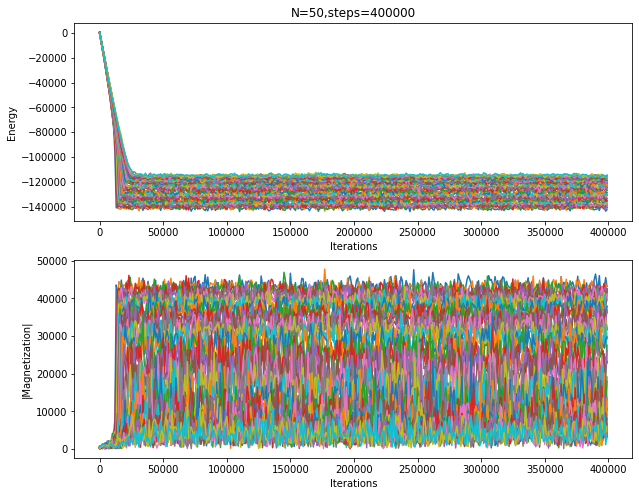

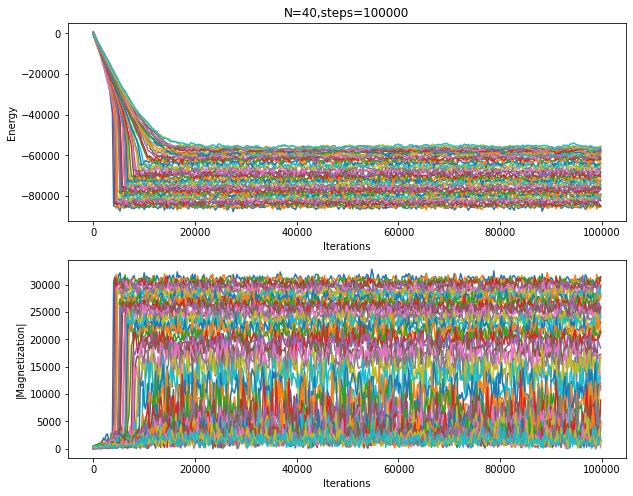

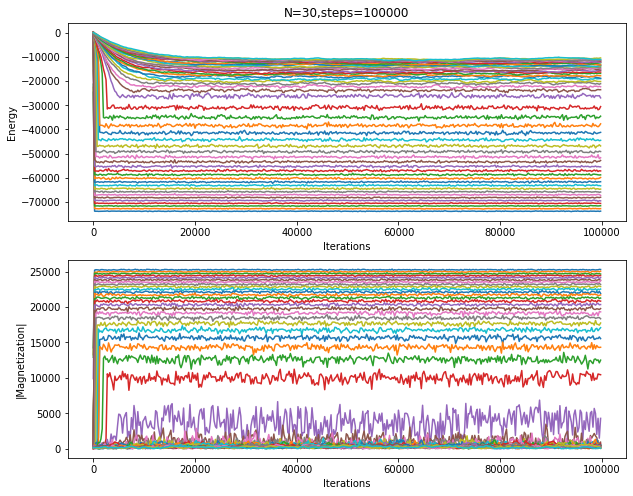

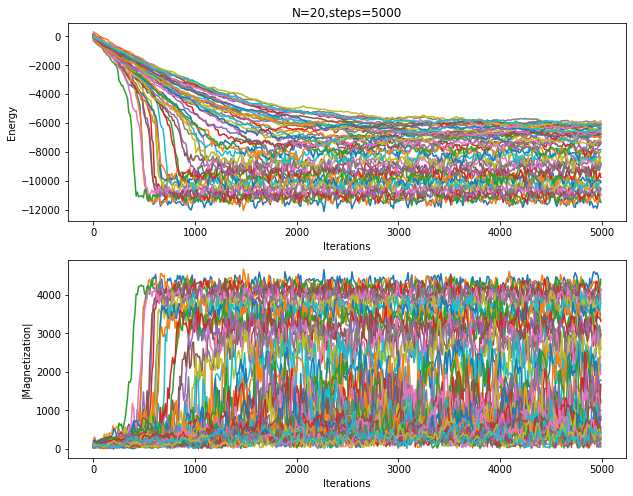

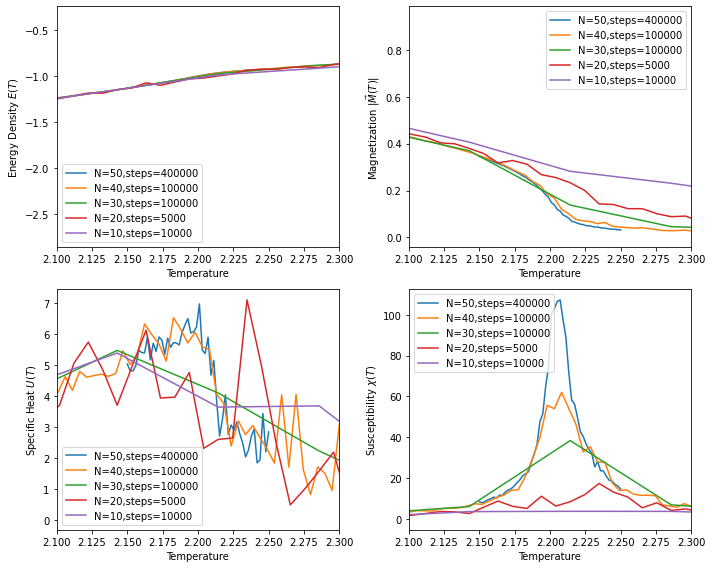

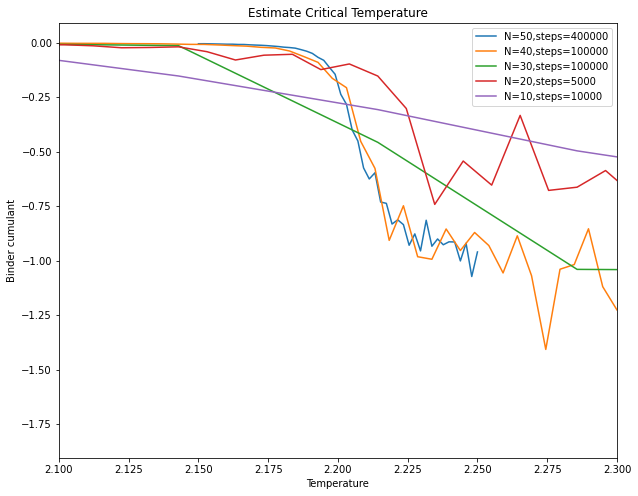

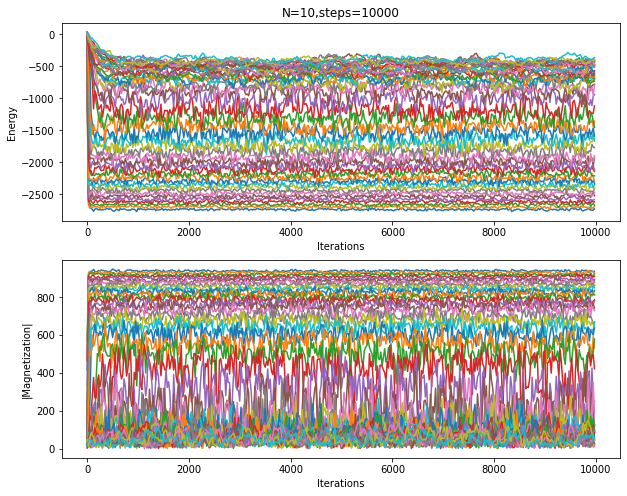

In [18]:
#!/bin/python3
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,8)
import matplotlib.pyplot as plt
import numpy as np
# Disable the deprecation warnings for reopening subplots for figure 1 and 2
import warnings
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning) 

for dir in ('narrow N=50','narrow N=40 steps=100e3','broad N_30 steps=100e3','narrow N_20 steps_5e3','N_10 steps_10000'):
    if len(dir):
        dir = 'Results/3D XY Wolff/{}/'.format(dir)
    energies = np.fromfile(dir+'energy.dat',dtype=np.double)
    mags = np.fromfile(dir+'magnetization.dat',dtype=np.double)
    dim,N,NT,steps,T0,Trange = np.genfromtxt(dir+'params.txt')
    dim = int(dim)
    N = int(N)
    NT = int(NT)
    steps = int(steps)
    T = np.linspace(T0,T0+Trange,NT)
    energies.shape = (NT,steps+1)
    mags.shape = (NT,steps,-1)
    vecDim = mags.shape[2]

    beta = energies[:,-1]
    energies = energies[:,:-1]

#     print(N,NT,steps)
#     print(mags)
#     print(energies)

    thermalize = int(steps*0.9)


    avg_energy = np.average(energies[:,thermalize:],axis=1)
    currentM_abs = np.average(np.linalg.norm(mags[:,thermalize:],axis=2),axis=1)

    chi_T = (np.average(np.linalg.norm(mags[:,thermalize:],axis=2)**2,axis=1)-currentM_abs**2)/(T*N**dim)
    C_T = (np.average(energies[:,thermalize:]**2,axis=1)-avg_energy**2)/(T*N**dim)


    xlim = [2.1,2.3]
#     xlim=None
    label='N={},steps={}'.format(N,steps)
    plt.figure(1)
    plt.subplot(221)
    plt.plot(T,avg_energy/N**dim,label=label)
    plt.xlabel("Temperature")
    plt.ylabel("Energy Density $E(T)$")
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.subplot(222)
    plt.plot(T,currentM_abs/N**dim,label=label)
    plt.xlabel("Temperature")
    plt.ylabel(r"Magnetization $|\vec{M}(T)|$")
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.subplot(223)
    plt.plot(T,C_T,label=label)
    plt.xlabel("Temperature")
    plt.ylabel("Specific Heat $U(T)$")
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.subplot(224)
    plt.plot(T,chi_T,label=label)
    plt.xlabel("Temperature")
    plt.ylabel("Susceptibility $\chi(T)$")
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.tight_layout()
    
    plt.figure(2)
    plt.title('Estimate Critical Temperature')
    plt.xlabel('Temperature')
    plt.ylabel('Binder cumulant')
    binder= 1-np.average(np.linalg.norm(mags[:,thermalize:],axis=2)**4,axis=1)/np.average(np.linalg.norm(mags[:,thermalize:],axis=2)**2,axis=1)**2
    plt.plot(T,binder,label=label)
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()

    plt.figure()
    plt.subplot(211)
    #plt.plot(np.arange(steps)[::100],energies[:,::100].T)
    plt.plot(np.arange(steps)[::steps//400],energies[:,::steps//400].T)# Too hard to see: ,':')
    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    plt.title(label)
    plt.subplot(212)
    
    plt.plot(np.arange(steps)[::steps//400],np.linalg.norm(mags[:,::steps//400],axis=2).T)# Too hard to see: ,':')
    plt.xlabel("Iterations")
    plt.ylabel("|Magnetization|")

print("Plotted")
plt.show()


## References

- "Simulation methods in physics: Lecture 4: Cluster Update Algorithms" by Kari Rummukainen https://www.mv.helsinki.fi/home/rummukai/simu/cluster.pdf
- "Critical Behaviour of the 3D XY-Model:A Monte Carlo Study" by Aloysius P. Gottlob and Martin Hasenbusch (1993): arXiv:cond-mat/9305020 (https://arxiv.org/pdf/cond-mat/9305020.pdf)
- "High-precision Monte Carlo study of several models in the three-dimensional U(1) universality class" by Wanwan Xu, Yanan Sun, Jian-Ping Lv, Youjin Deng (2019):  	arXiv:1908.10990 \[cond-mat.stat-mech\] (https://arxiv.org/pdf/1908.10990.pdf
- “Cluster Monte Carlo algoirthms” by Werner Krauth (2008): arXiv:cond-mat/0311623 (https://arxiv.org/pdf/cond-mat/0311623.pdf)

## Apendix

Note that the below code is not commented as well as the finished code above. It follows essentially the same layout as the finished, well-commented code, though, so it should be understandable.

### 2D Ising

Results showing consistency between the Wolff cluster update and Metropolis update results.
![image](Results/2d-Params.png)

```cpp
//Ising2D.cpp
#include <iostream>
#include <random>
#include <cmath>
#include <bits/stdc++.h>

//#undef assert
//#define assert(...) (void(0))

using namespace std;

// Create the grid
using Vec = double;
constexpr int N = 20;
constexpr int NT = 50;
constexpr double J = 1;
bool grid[N][N];
constexpr int steps = 1e3;
constexpr double T0 = 0.5; // lowest temperature
constexpr double TRange = 2.5; // delta to highest temperature

#define START_UP true
#define DIMENSIONS 2

// Setup random number generator for float and integer distributions.
std::random_device rd;
//std::mt19937 e2(rd());
ranlux48_base e2(32);//rd());
std::uniform_real_distribution<> dist(0, 1);
std::uniform_int_distribution<> randint{0, N-1};
std::uniform_int_distribution<> randbool{0, 1};

/// Get random int [0,N).
inline int RandInt()
{
    return randint(e2);
}

/// Get random double [0,1).
inline double Rand()
{
    return dist(e2);
}

/// Set's a random value for the grid at x and y
inline void SetRandom(int x, int y)
{
    grid[x][y] = randbool(e2);
}

/// Convenience function to get the spin at the given x and y
inline Vec Val(int x, int y)
{
    return grid[x][y] ? 1 : -1;
}

/// Convenience function to get the spin at the given linear index
inline Vec IVal(int i)
{
    return Val(i/N,i%N);
}

/// Safer convenience function to get the spin at the given x and y, applying %N wrapping.
inline Vec SVal(int x, int y)
{
    return grid[(x+N)%N][(y+N)%N] ? 1 : -1;
}

/// Flips the grid value at the given point.
inline void Flip(int x, int y)
{
    grid[x][y] = !grid[x][y];
}

/// Returns the energy for the grid. Counts each neighbor pairing only once.
double Energy()
{
    double energy = 0;
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
        {
            energy += -J*Val(x,y)*Val((x+1)%N,y);
            energy += -J*Val(x,y)*Val(x,(y+1)%N);
        }
    return energy;
}

/// Returns the magnetization of the grid.
Vec Magnetization()
{
    Vec energy = 0;
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            energy += Val(x,y);
    return energy;
}

/// Resets the grid. Get's starting magnetization and energy.
inline void ResetGrid(double& energy, Vec& magnetization)
{
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
#ifdef START_UP
            grid[x][y] = {1};
#else
            SetRandom(x,y);
#endif
    energy = Energy();
    magnetization = Magnetization();
}

/// Performs a step of the metropolis update algorithm.
void MetropolisUpdate(double beta, double& energy, Vec& magnetization)
{
    int x = RandInt();
    int y = RandInt();

    auto pt = Val(x,y);
    Vec neighbors[] = {SVal(x+1,y), SVal(x-1,y),
                       SVal(x,y+1), SVal(x,y-1)};
    double dH = 0, dM = 0;
    // By doubling the values, we account for the energy counting each pair once, regardless of order,
    // with the energy +J to -J, for example, so dH would be -2J, not -J.
    for (auto n : neighbors)
        dH += 2*J*pt*n;

    // For decreasing energy (dH<0) we always accept as thresh > 1, so our random number will be less than it.
    // Otherwise we conditionally accept it based on the inverse temperature beta.
    double thresh = exp(-dH*beta);
    double p = Rand();
    if (p < thresh)
    {
        Flip(x,y);
        dM = -2*pt;
    }
    else
    {
        dH = 0;
    }

//    assert(abs(Energy()-energy - dH) < 1e-4);

    energy += dH;
    magnetization += dM;
}

/// Perform Wolff cluster update.
void WolffUpdate(double beta, double& energy, Vec& magnetization)
{
    int x = RandInt();
    int y = RandInt();

    int frontierIdcs[N*N];
    bool cluster[N][N] = {false,};

    // Initialize our frontier with the one point
    int frontierSize = 1;
    int frontierPos = 0;
    frontierIdcs[0] = x*N+y;

    struct xy
    {
        int x,y;
    };
    auto AddFrontier = [&](const xy& n)
    {
        if (frontierPos+frontierSize >= N*N)
        {
            memmove(frontierIdcs,frontierIdcs+frontierPos,frontierSize*sizeof(int));
            frontierPos=0;
            cout << "Reset frontier location" << endl;
        }
        frontierIdcs[frontierPos+frontierSize] = n.x*N+n.y;
        frontierSize += 1;
    };


    int iterations = 0;
    for (; frontierSize; ++frontierPos,--frontierSize)
    {
        // Get the cluster index, skip if it is already in the cluster.
        int i = frontierIdcs[frontierPos];
        int ix = i / N;
        int iy = i % N;
        if (cluster[ix][iy])
            continue;

        // Add this point to the cluster
        cluster[ix][iy] = true;

        // Compare to teh neighboring values
        auto v = Val(ix,iy);
        for (xy n : {xy{1,0},xy{-1,0},xy{0,1},xy{0,-1}})
        {
            n.x = (N+ix+n.x)%N;
            n.y = (N+iy+n.y)%N;
            auto nv = Val(n.x,n.y);
            // If it is parallel
            if (v*nv > 0)
            {
                float p = (1 - exp(-2*J*beta));
                // With probability 1-exp(-2*J*beta) add it to the frontier
                if (Rand() <  p)
                    AddFrontier(n);
            }
        }
        // And now that we've finished with this point, go ahead and flip it.
        Flip(ix,iy);

        iterations++;
    }

    // Recalculate energy and magnetization
    energy = Energy();
    magnetization = Magnetization();
}


double energies[NT][steps+1] = {0,};
Vec magnetizations[NT][steps] = {0,};



int main()
{
    cout << "Starting" << endl;
    for (int b = 0; b < NT; ++b)
    {
        double energy,magnetization;
        ResetGrid(energy,magnetization);
        double T = NT > 1 ? T0 + b*TRange/(NT-1) : T0;
        double beta = 1/T;
        energies[b][steps] = beta;
        for (int i = 0; i < steps; ++i)
        {
//            MetropolisUpdate(beta,energy,magnetization);
            WolffUpdate(beta,energy,magnetization);
            energies[b][i] = energy;
            magnetizations[b][i] = magnetization;
//            if (i % 1000 == 0 && abs(energy - Energy()) > 1e-5)
//            {
//                cout << "Failed with E = " << energy;
//                cout << " rather than E = " << Energy() << endl;
//                assert(false);
//            }
        }
    }
    cout << "Finished" << endl;

    // Write to file

    ofstream outE("energy.dat", ios::out | ios::binary);
    ofstream outM("magnetization.dat", ios::out | ios::binary);
    ofstream outP("params.txt", ios::out);
    if(!outE || !outM || !outP) {
      cout << "Cannot open file.";
      return 1;
     }

    outE.write((char *) &energies, sizeof energies);
    outM.write((char *) &magnetizations, sizeof magnetizations);

    outP << DIMENSIONS << " " << N << " " << NT << " " << steps << " " << T0 << " " << TRange;

    outE.close();
    outM.close();
    outP.close();

    system("python3 Plot.py");
    return 0;
}
```



### 3D Ising


Results showing consistency between the Wolff cluster update and Metropolis update results.
![image](Results/3d-Params.png)

```cpp
//Ising3D.cpp
#include <iostream>
#include <random>
#include <cmath>
#include <bits/stdc++.h>

//#undef assert
//#define assert(...) (void(0))

using namespace std;

// Create the grid
using Vec = double;
constexpr int N = 10;
constexpr int NT = 50;
constexpr double J = 1;
bool grid[N][N][N];
constexpr int steps = 1e3;
constexpr double T0 = 2.5; // lowest temperature
constexpr double TRange = 3.5; // delta to highest temperature

//#define START_UP
#define DIMENSIONS 3

// Setup random number generator for float and integer distributions.
std::random_device rd;
//std::mt19937 e2(rd());
ranlux48_base e2(32);//rd());
std::uniform_real_distribution<> dist(0, 1);
std::uniform_int_distribution<> randint{0, N-1};
std::uniform_int_distribution<> randbool{0, 1};

/// Get random int [0,N).
inline int RandInt()
{
    return randint(e2);
}

/// Get random double [0,1).
inline double Rand()
{
    return dist(e2);
}

/// Set's a random value for the grid at x and y
inline void SetRandom(int x, int y, int z)
{
    grid[x][y][z] = randbool(e2);
}

/// Convenience function to get the spin at the given x and y
inline Vec Val(int x, int y, int z)
{
    return grid[x][y][z] ? 1 : -1;
}

/// Safer convenience function to get the spin at the given x and y, applying %N wrapping.
inline Vec SVal(int x, int y, int z)
{
    return grid[(x+N)%N][(y+N)%N][(z+N)%N] ? 1 : -1;
}

/// Flips the grid value at the given point.
inline void Flip(int x, int y, int z)
{
    grid[x][y][z] = !grid[x][y][z];
}

/// Returns the energy for the grid. Counts each neighbor pairing only once.
double Energy()
{
    double energy = 0;
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            for (int z = 0; z < N; ++z)
            {
                energy += -J*Val(x,y,z)*Val((x+1)%N,y,z);
                energy += -J*Val(x,y,z)*Val(x,(y+1)%N,z);
                energy += -J*Val(x,y,z)*Val(x,y,(z+1)%N);
            }
    return energy;
}

/// Returns the magnetization of the grid.
Vec Magnetization()
{
    Vec energy = 0;
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            for (int z = 0; z < N; ++z)
                energy += Val(x,y,z);
    return energy;
}

/// Resets the grid. Get's starting magnetization and energy.
inline void ResetGrid(double& energy, Vec& magnetization)
{
    for (int x = 0; x < N; ++x)
        for (int y = 0; y < N; ++y)
            for (int z = 0; z < N; ++z)
#ifdef START_UP
                grid[x][y][z] = {1};
#else
                SetRandom(x,y,z);
#endif
    energy = Energy();
    magnetization = Magnetization();
}

/// Performs a step of the metropolis update algorithm.
void MetropolisUpdate(double beta, double& energy, Vec& magnetization)
{
    int x = RandInt();
    int y = RandInt();
    int z = RandInt();

    auto pt = Val(x,y,z);
    Vec neighbors[] = {SVal(x+1,y,z), SVal(x-1,y,z),
                       SVal(x,y+1,z), SVal(x,y-1,z),
                       SVal(x,y,z+1), SVal(x,y,z-1)};
    double dH = 0, dM = 0;
    // By doubling the values, we account for the energy counting each pair once, regardless of order,
    // with the energy +J to -J, for example, so dH would be -2J, not -J.
    for (auto n : neighbors)
        dH += 2*J*pt*n;

    // For decreasing energy (dH<0) we always accept as thresh > 1, so our random number will be less than it.
    // Otherwise we conditionally accept it based on the inverse temperature beta.
    double thresh = exp(-dH*beta);
    double p = Rand();
    if (p < thresh)
    {
        Flip(x,y,z);
        dM = -2*pt;
    }
    else
    {
        dH = 0;
    }

//    assert(abs(Energy()-energy - dH) < 1e-4);

    energy += dH;
    magnetization += dM;
}

/// Perform Wolff cluster update.
void WolffUpdate(double beta, double& energy, Vec& magnetization)
{
    int x = RandInt();
    int y = RandInt();
    int z = RandInt();

    int frontierIdcs[N*N*N];
//    bool cluster[N][N][N] = {false,};
    bool cluster[N*N*N] = {false,};
    memset(cluster,false,sizeof cluster);

    // Initialize our frontier with the one point
    int frontierSize = 1;
    int frontierPos = 0;
    frontierIdcs[0] = x*N*N+y*N+z;

    struct xy
    {
        int x,y,z;
    };
    auto AddFrontier = [&](const xy& n)
    {
        if (frontierPos+frontierSize >= N*N*N)
        {
            memmove(frontierIdcs,frontierIdcs+frontierPos,frontierSize*sizeof(int));
            frontierPos=0;
            cout << "Reset frontier location \n";
        }
        frontierIdcs[frontierPos+frontierSize] = n.x*N*N+n.y*N+n.z;
        frontierSize += 1;
    };


    int iterations = 0;
    for (; frontierSize; ++frontierPos,--frontierSize)
    {
        // Get the cluster index, skip if it is already in the cluster.
        int i = frontierIdcs[frontierPos];
        int ix = i / N / N;
        int iy = (i/N) % N;
        int iz = i % N;
        if (cluster[i])
            continue;

        // Add this point to the cluster
        cluster[i] = true;

        // Compare to teh neighboring values
        auto v = Val(ix,iy,iz);
        for (xy n : {xy{1,0,0},xy{-1,0,0},xy{0,1,0},xy{0,-1,0},xy{0,0,1},xy{0,0,-1}})
        {
            n.x = (N+ix+n.x)%N;
            n.y = (N+iy+n.y)%N;
            n.z = (N+iz+n.z)%N;
            auto nv = Val(n.x,n.y,n.z);
            // If it is parallel
            if (v*nv > 0)
            {
                float p = (1 - exp(-2*J*beta));
                // With probability 1-exp(-2*J*beta) add it to the frontier
                if (Rand() <  p)
                    AddFrontier(n);
            }
        }
        // And now that we've finished with this point, go ahead and flip it.
        Flip(ix,iy,iz);

        iterations++;
    }

    // Recalculate energy and magnetization
    energy = Energy();
    magnetization = Magnetization();
}


double energies[NT][steps+1] = {0,};
Vec magnetizations[NT][steps] = {0,};



int main()
{
    cout << "Starting" << endl;
    for (int b = 0; b < NT; ++b)
    {
        double energy,magnetization;
        ResetGrid(energy,magnetization);
        double T = NT > 1 ? T0 + b*TRange/(NT-1) : T0;
        double beta = 1/T;
        energies[b][steps] = beta;
        for (int i = 0; i < steps; ++i)
        {
//            MetropolisUpdate(beta,energy,magnetization);
            WolffUpdate(beta,energy,magnetization);
            energies[b][i] = energy;
            magnetizations[b][i] = magnetization;
//            if (i % 1000 == 0 && abs(energy - Energy()) > 1e-5)
//            {
//                cout << "Failed with E = " << energy;
//                cout << " rather than E = " << Energy() << endl;
//                assert(false);
//            }
        }
    }
    cout << "Finished" << endl;

    // Write to file

    ofstream outE("energy.dat", ios::out | ios::binary);
    ofstream outM("magnetization.dat", ios::out | ios::binary);
    ofstream outP("params.txt", ios::out);
    if(!outE || !outM || !outP) {
      cout << "Cannot open file.";
      return 1;
     }

    outE.write((char *) &energies, sizeof energies);
    outM.write((char *) &magnetizations, sizeof magnetizations);

    outP << DIMENSIONS << " " << N << " " << NT << " " << steps << " " << T0 << " " << TRange;

    outE.close();
    outM.close();
    outP.close();

    system("python3 Plot.py");
    return 0;
}

```